One can use this code to fine tune stable diffusion v1.5. To fine-tune Stable Diffusion v1.5, you need an image-to-prompt dataset. If your dataset lacks prompts for corresponding images, you can generate them using the caption generation pipeline with clip_with_recursive_prompt.py.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from pathlib import Path
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torch.nn.functional as F
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from peft.utils import get_peft_model_state_dict
from diffusers.utils import convert_state_dict_to_diffusers
from PIL import Image
import pandas as pd
from diffusers.training_utils import compute_snr
import cv2

In [19]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet

In [25]:
def setup_models_for_training(model_name, rank: int=128):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    # freeze all weights
    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False

    # config LoRA
    unet_lora_config = LoraConfig(
        r=rank,
        lora_alpha=rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    unet.add_adapter(unet_lora_config)

    # set trainaible weights to float32
    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    return tokenizer, text_encoder, vae, scheduler, unet

def get_lora_params(unet):
    return [p for p in filter(lambda p: p.requires_grad, [p for p in unet.pargameters()])]

In [26]:
from dataclasses import dataclass
@dataclass
class TrainingConfig():
    train_steps: int = 100
    lr: float = 1e-5
    batch_size: int = 4
    accumulation_steps: int = 2
    rank: int = 128
    max_grad_norm: float = 1.0
    pretrained_name: str = "runwayml/stable-diffusion-v1-5"
    snr_gamma: float = -1
    seed: int = -1
    CSV_PATH = '/kaggle/input/carpets/Carpets/desc.csv'
    BASE_IMAGE_DIR = '/kaggle/input/carpets/Carpets'





In [27]:
import os
class CarpetWallpaperDataset(Dataset):
    def __init__(self, csv_path, base_image_dir,tokenizer):
        self.dataframe = pd.read_csv(csv_path)
        self.base_image_dir = base_image_dir
        self.tokenizer = tokenizer
        self.train_tranforms = transforms.Compose(
              [
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Resize((1024,1024)),
                  transforms.Normalize([0.5], [0.5]),
              ]
        )

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Construct full image path
        relative_path = self.dataframe.iloc[idx]['image']
        full_image_path = os.path.join(self.base_image_dir, relative_path)

        # Load image
        image = Image.open(full_image_path).convert('RGB')

        image_tensor=self.train_tranforms(image)


        input_ids = self.tokenizer(
            self.dataframe.iloc[idx]['prompt'],
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]
        # Get corresponding text prompt
        # text_prompt = self.dataframe.iloc[idx]['prompt']

        return {"pixel_values": image_tensor,
                 "input_ids": input_ids}

In [28]:
def train(
    tokenizer: CLIPTokenizer,
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    scheduler: DDPMScheduler,
    unet: UNet2DConditionModel,
    config: TrainingConfig,
    device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    lora_params = get_lora_params(unet)

    text_encoder.to(device).eval()
    vae.to(device).eval()
    unet.to(device).train()

    # data set
    train_dataset = CarpetWallpaperDataset(config.CSV_PATH,config.BASE_IMAGE_DIR, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    # optimizer
    steps_per_epoch = math.ceil(len(train_dataloader) / config.accumulation_steps)
    epochs = math.ceil(config.train_steps / steps_per_epoch)

    lr = config.lr * config.accumulation_steps * config.batch_size
    optimizer = torch.optim.AdamW(lora_params, lr=lr)

    scaler = torch.cuda.amp.GradScaler()

    # progress bar setup
    global_step = 0
    progress_bar = tqdm(
        range(config.train_steps),
        desc="Steps"
    )

    print(f"configs: {config}")
    print(f"epochs: {epochs}")
    print(f"steps per epoch: {steps_per_epoch}")
    print(f"total steps: {config.train_steps}")
    print(f"accumulation steps: {config.accumulation_steps}")
    print(f"total batch size: {config.batch_size * config.accumulation_steps}")
    print(f"lr: {lr}")

    losses = []
    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device), return_dict=False)[0]

                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,)).long().to(device)

                with torch.no_grad():
                    batch["pixel_values"] = batch["pixel_values"].type(torch.float16)
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if config.snr_gamma > 0:
                    # should converge faster with snr_gamma, however works well with unweighted mse
                    # https://arxiv.org/abs/2303.09556
                    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py
                    snr = compute_snr(scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(
                        dim=1
                    )[0]
                    mse_loss_weights = mse_loss_weights / snr
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

            global_step+=1
            scaler.scale(loss).backward()

            if global_step % config.accumulation_steps == 0:
                if config.max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(lora_params, config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                progress_bar.update(1)

            losses.append(loss.item())

            progress_bar.set_postfix({"loss": losses[-1]})
            if global_step / config.accumulation_steps >= config.train_steps:
                break

    return {
        "losses": losses
    }

In [33]:
try:
    # in case of rerun, to make sure we free up GPU before calling train
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    pass

config = TrainingConfig()
config.lr = 1e-5
config.rank = 62
config.train_steps = 1000
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

model= setup_models_for_training(config.pretrained_name, rank=config.rank)

outputs = train(
    *models,
    config,
)

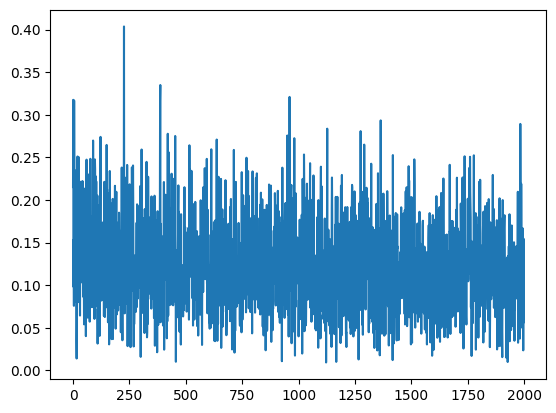

In [17]:
plt.plot(outputs["losses"])
plt.show()

In [18]:
unet = models[-1]
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [19]:
StableDiffusionPipeline.save_lora_weights(
    save_directory="./out",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

In [20]:
!ls -l -h ./out/pytorch_lora_weights.safetensors

-rw-r--r-- 1 root root 48M Jan 27 10:01 ./out/pytorch_lora_weights.safetensors


In [8]:
df = pd.read_csv(config.CSV_PATH)e

In [10]:
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
relative_path = df.iloc[0]['image']
full_image_path = os.path.join(config.BASE_IMAGE_DIR, relative_path)
prompt_training = df.iloc[0]["prompt"]
prompt_new = "a dark forest, detailed, 8k"
num_inference_steps=35
seed = 3

In [11]:
def generate(pipeline, prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipeline(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]

In [ ]:
# mejan 
pipe = DiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)

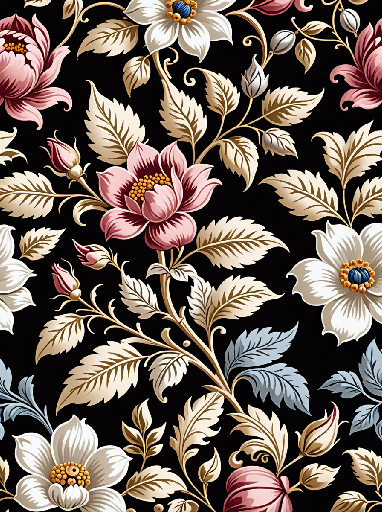

In [51]:
# mejan
relative_path = df.iloc[32]['image']
full_image_path = os.path.join(config.BASE_IMAGE_DIR, relative_path)
prompt_training = df.iloc[32]["prompt"]
image=Image.open(full_image_path)
image


  0%|          | 0/35 [00:00<?, ?it/s]

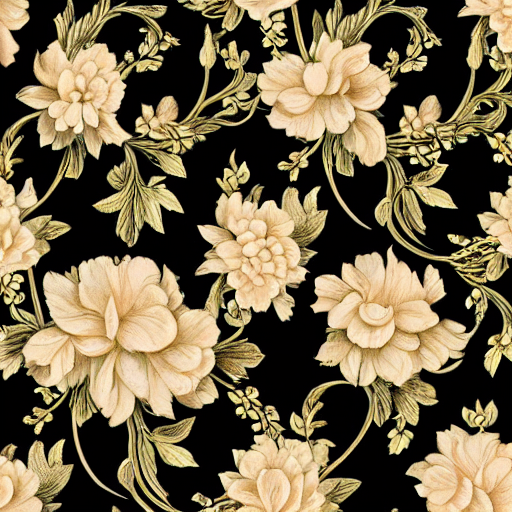

In [14]:
# mejan
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

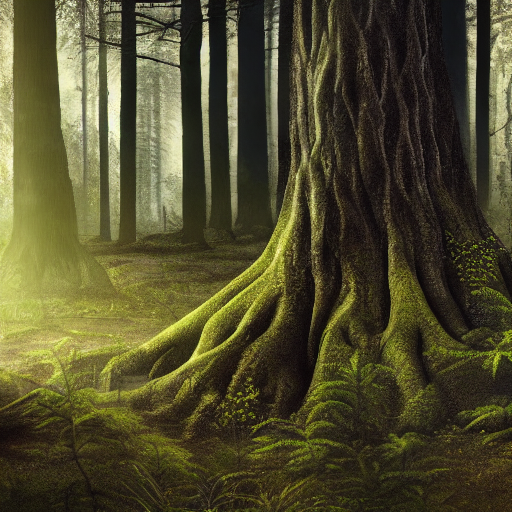

In [27]:
generate(pipe, prompt_new, seed)

In [16]:
# mejan
pipe.load_lora_weights("/kaggle/input/sd-weights/pytorch_lora_weights.safetensors")

  0%|          | 0/35 [00:00<?, ?it/s]

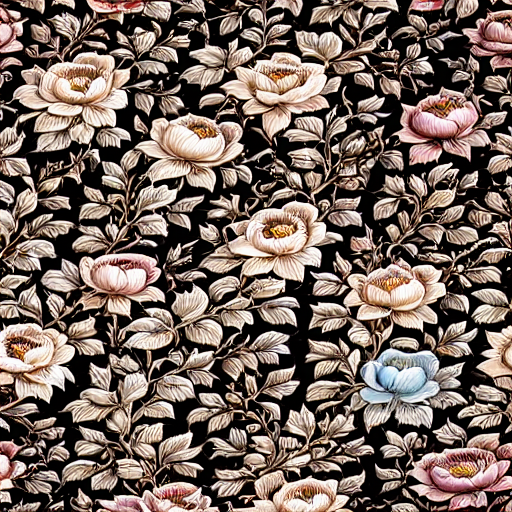

In [17]:
#mejan
generate(pipe, prompt_training, seed)

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)
# pipe.load_lora_weights("/kaggle/input/sd-weights/pytorch_lora_weights.safetensors")

pipe = pipe.to("cuda")



In [71]:
from diffusers.utils import load_image
url='https://designcompetition.explorug.online/images/Border/2/16.webp'
image=load_image(url)

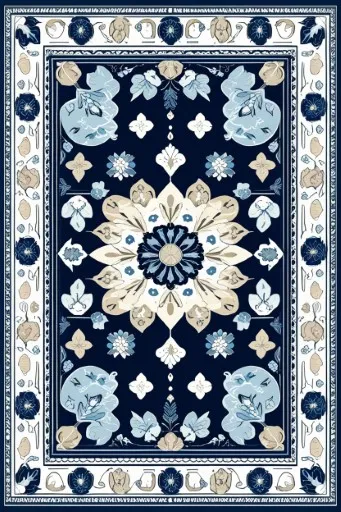

In [72]:
image

In [73]:



prompt="a blue rug with a floral design on it, shutterstock, arabesque, folkloric illustration, navy-blue, navy"
bad_prompt="blurry, simple, monochrome, realistic, photographic, dark background, low detail"
# Generate new image
result = pipe(
    prompt=prompt,
    negative_prompt=bad_prompt,
    image=image,
    strength=0.75,  # Controls how much to transform the image (0-1)
    guidance_scale=7.5  # Controls how closely to follow the prompt
).images[0]


  0%|          | 0/37 [00:00<?, ?it/s]

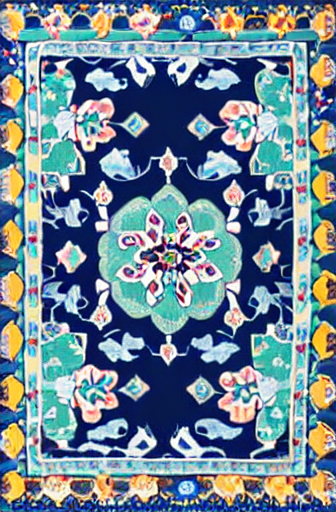

In [74]:
result

In [69]:
result.save('result.jpg')

In [ ]:
import cv2
import numpy as np
from PIL import Image

# Prepare canny edge detection
image = cv2.imread("/kaggle/working/result.jpg")
canny_image = cv2.Canny(image, 100, 200)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

In [23]:
canny_image.save('canny_result.jpg')

In [ ]:
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter
import torch
# adapter = T2IAdapter.from_pretrained("TencentARC/t2iadapter_canny_sd15v2", torch_dtype=torch.float16)

pipe = StableDiffusionAdapterPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)
pipe.load_lora_weights("/kaggle/input/sd-weights/pytorch_lora_weights.safetensors")

pipe = pipe.to("cuda")

In [ ]:
image = pipe(
    prompt="your prompt here",
    image=adapter_image,  # Your conditioning image
    num_inference_steps=30
).images[0]

# experiment end